In [12]:
from IPython.core.interactiveshell import InteractiveShell

# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(15, resample=Image.BILINEAR),
        #transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        #transforms.Normalize([0.5], [0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
       
        #transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
#         'test': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
       
#         #transforms.Lambda(lambda x: x.repeat(3,1,1)),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
}


data_dir = '../src/output/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
n_classes = len(class_names)

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], num_workers=8, batch_size=64, shuffle=True) for x in ['train', 'val']}

In [15]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print('total parameters: {}'.format(total_params))
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print('total_trainable_params: {}'.format(total_trainable_params))

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [16]:
# Location of data
datadir = '../src/output/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'

save_file_name = 'resnet50-deboer.pth'
checkpoint_path = 'resnet50-deboer.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print('Train on gpu: {}'.format(train_on_gpu))

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print('{} gpus detected'.format(gpu_count))
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected


In [17]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []


# Iterate through each category
for d in os.listdir(traindir):
    if len(os.listdir(traindir + d)) > 0:
        
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        #test_imgs = os.listdir(testdir + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        #n_test.append(len(test_imgs))



# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid}).sort_values('category')


cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail(50)

,category,n_train,n_valid
19,soccer,416,10
85,construction_site,396,10
105,ceremony,292,10
3,portrait_group,255,10
15,music_performance,240,10


,category,n_train,n_valid
27,butchers_shop,23,10
75,game_room,23,10
73,shed,23,10
45,bookstore,23,10
1,rowing,23,10
114,car_shop,21,10
50,tower,21,10
18,person,20,10
33,pond,20,10
127,beauty_salon,20,10


In [18]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# # Example image
# x = Image.open(traindir + 'accident/2.jpg')
# np.array(x).shape
# imshow(x)

In [19]:
# # Image transformations
# image_transforms = {
#     # Train uses data augmentation
#     'train':
#     transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.ColorJitter(),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),  # Image net standards
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x.repeat(3,1,1)),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# #         transforms.Normalize([0.485, 0.456, 0.406],
# #                              [0.229, 0.224, 0.225])  # Imagenet standards
#     ]),
#     # Validation does not use augmentation
#     'val':
#     transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x.repeat(3,1,1)),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#     ]),
#     # Test does not use augmentation
#     'test':
#     transforms.Compose([
#         transforms.Resize(size=256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x.repeat(3,1,1)),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#     ]),
# }

In [20]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [21]:


ex_img = Image.open(traindir + 'accident/NL-HlmNHA_1478_20140K00_18.jpg')
imshow(ex_img)



FileNotFoundError: [Errno 2] No such file or directory: '../src/output/train/accident/NL-HlmNHA_1478_20140K00_18.jpg'

<Figure size 1728x1728 with 0 Axes>

NameError: name 'ex_img' is not defined

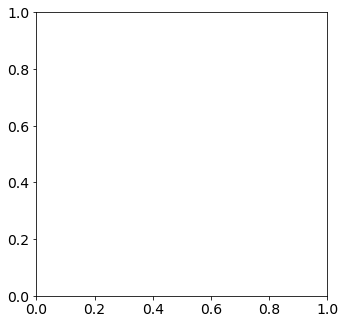

In [22]:
t = data_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [24]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=data_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=data_transforms['val']),
#     'test':
#     datasets.ImageFolder(root=testdir, transform=data_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
#     'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [25]:
n_classes = len(cat_df)
print('There are {} different classes.'.format(n_classes))


There are 134 different classes.


In [26]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

NameError: name 'model' is not defined

In [22]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

NameError: name 'data' is not defined

In [27]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [31]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)


/home/melvin/.local/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


total parameters: 24067014
total_trainable_params: 558982
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 5

In [27]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image



def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img)
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    img = img.transpose((2, 0, 1)) / 256
    
    

    #Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor



def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class



np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = validdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()



In [28]:
x = process_image(validdir + 'running/NL-HlmNHA_1478_01367_G.jpg')
x.shape

FileNotFoundError: [Errno 2] No such file or directory: '../src/output/val/running/NL-HlmNHA_1478_01367_G.jpg'

In [146]:
ax, image = imshow_tensor(x)

NameError: name 'x' is not defined

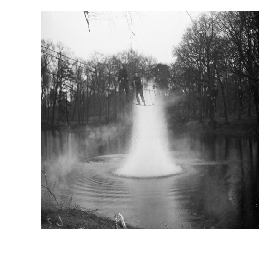

In [33]:
_ = imshow_tensor(process_image(random_test_image()))

In [34]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([0.1897257 , 0.17582841, 0.13774271, 0.10627459, 0.08946984],
       dtype=float32),
 ['saint_niclaus', 'music_performance', 'theatre', 'dancing', 'flowers'],
 'theatre')

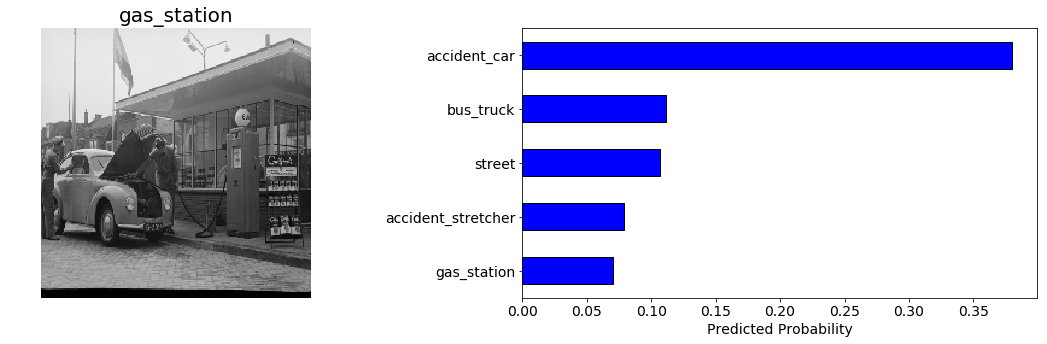

In [69]:
display_prediction(random_test_image(), model, topk=5)

In [150]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=['top{}'.format(i) for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [152]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['val'], criterion)
results.head()

,class,top1,top5,loss
0,accident_car,40.0,100.0,1.373096
1,accident_stretcher,0.0,0.0,8.255204
2,accident_train,100.0,100.0,0.257692
3,airplane,40.0,80.0,2.269134
4,amphitheater,20.0,80.0,3.080137


In [153]:
results

,class,top1,top5,loss
0,accident_car,40.0,100.0,1.373096
1,accident_stretcher,0.0,0.0,8.255204
2,accident_train,100.0,100.0,0.257692
3,airplane,40.0,80.0,2.269134
4,amphitheater,20.0,80.0,3.080137
5,amusement_park,0.0,0.0,9.698925
6,animals,20.0,60.0,2.992724
7,animals_cow,20.0,100.0,3.657078
8,animals_dog,0.0,20.0,6.299457
9,animals_horse,40.0,80.0,1.486511


In [170]:
# nb_classes = n_classes

# confusion_matrix = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(dataloaders['val']):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1

# print(confusion_matrix)

In [55]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        
acc_results = np.zeros((len(test_loader.dataset), len(topk)))

NameError: name 'test_loader' is not defined

In [60]:
y_pred = []
y_true = []
with torch.no_grad():

    # Testing loop
    for data, targets in dataloaders['val']:

        # Tensors to gpu
        if train_on_gpu:
            data, targets = data.to('cuda'), targets.to('cuda')

        # Raw model output
        out = model(data)
        # Iterate through each example
        for pred, true in zip(out, targets):
            output = pred.unsqueeze(0).to('cuda') 
            target = true.unsqueeze(0).to('cuda')
            
            pred = output.topk(1, dim=1, largest=True, sorted=True)[1]
            y_pred.append(pred.item())
            y_true.append(true.item())
            
#         with torch.no_grad():
#             maxk = 1
#             batch_size = target.size(0)
            
#             _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
#             pred = pred.t()
#             print(pred.item())
            
            #classes.append(model.idx_to_class[true.item()])
            
            
            
    

In [61]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'# Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    fig, ax = plt.subplots(figsize=(50,50))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")# Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.2 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.6 0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.6]]


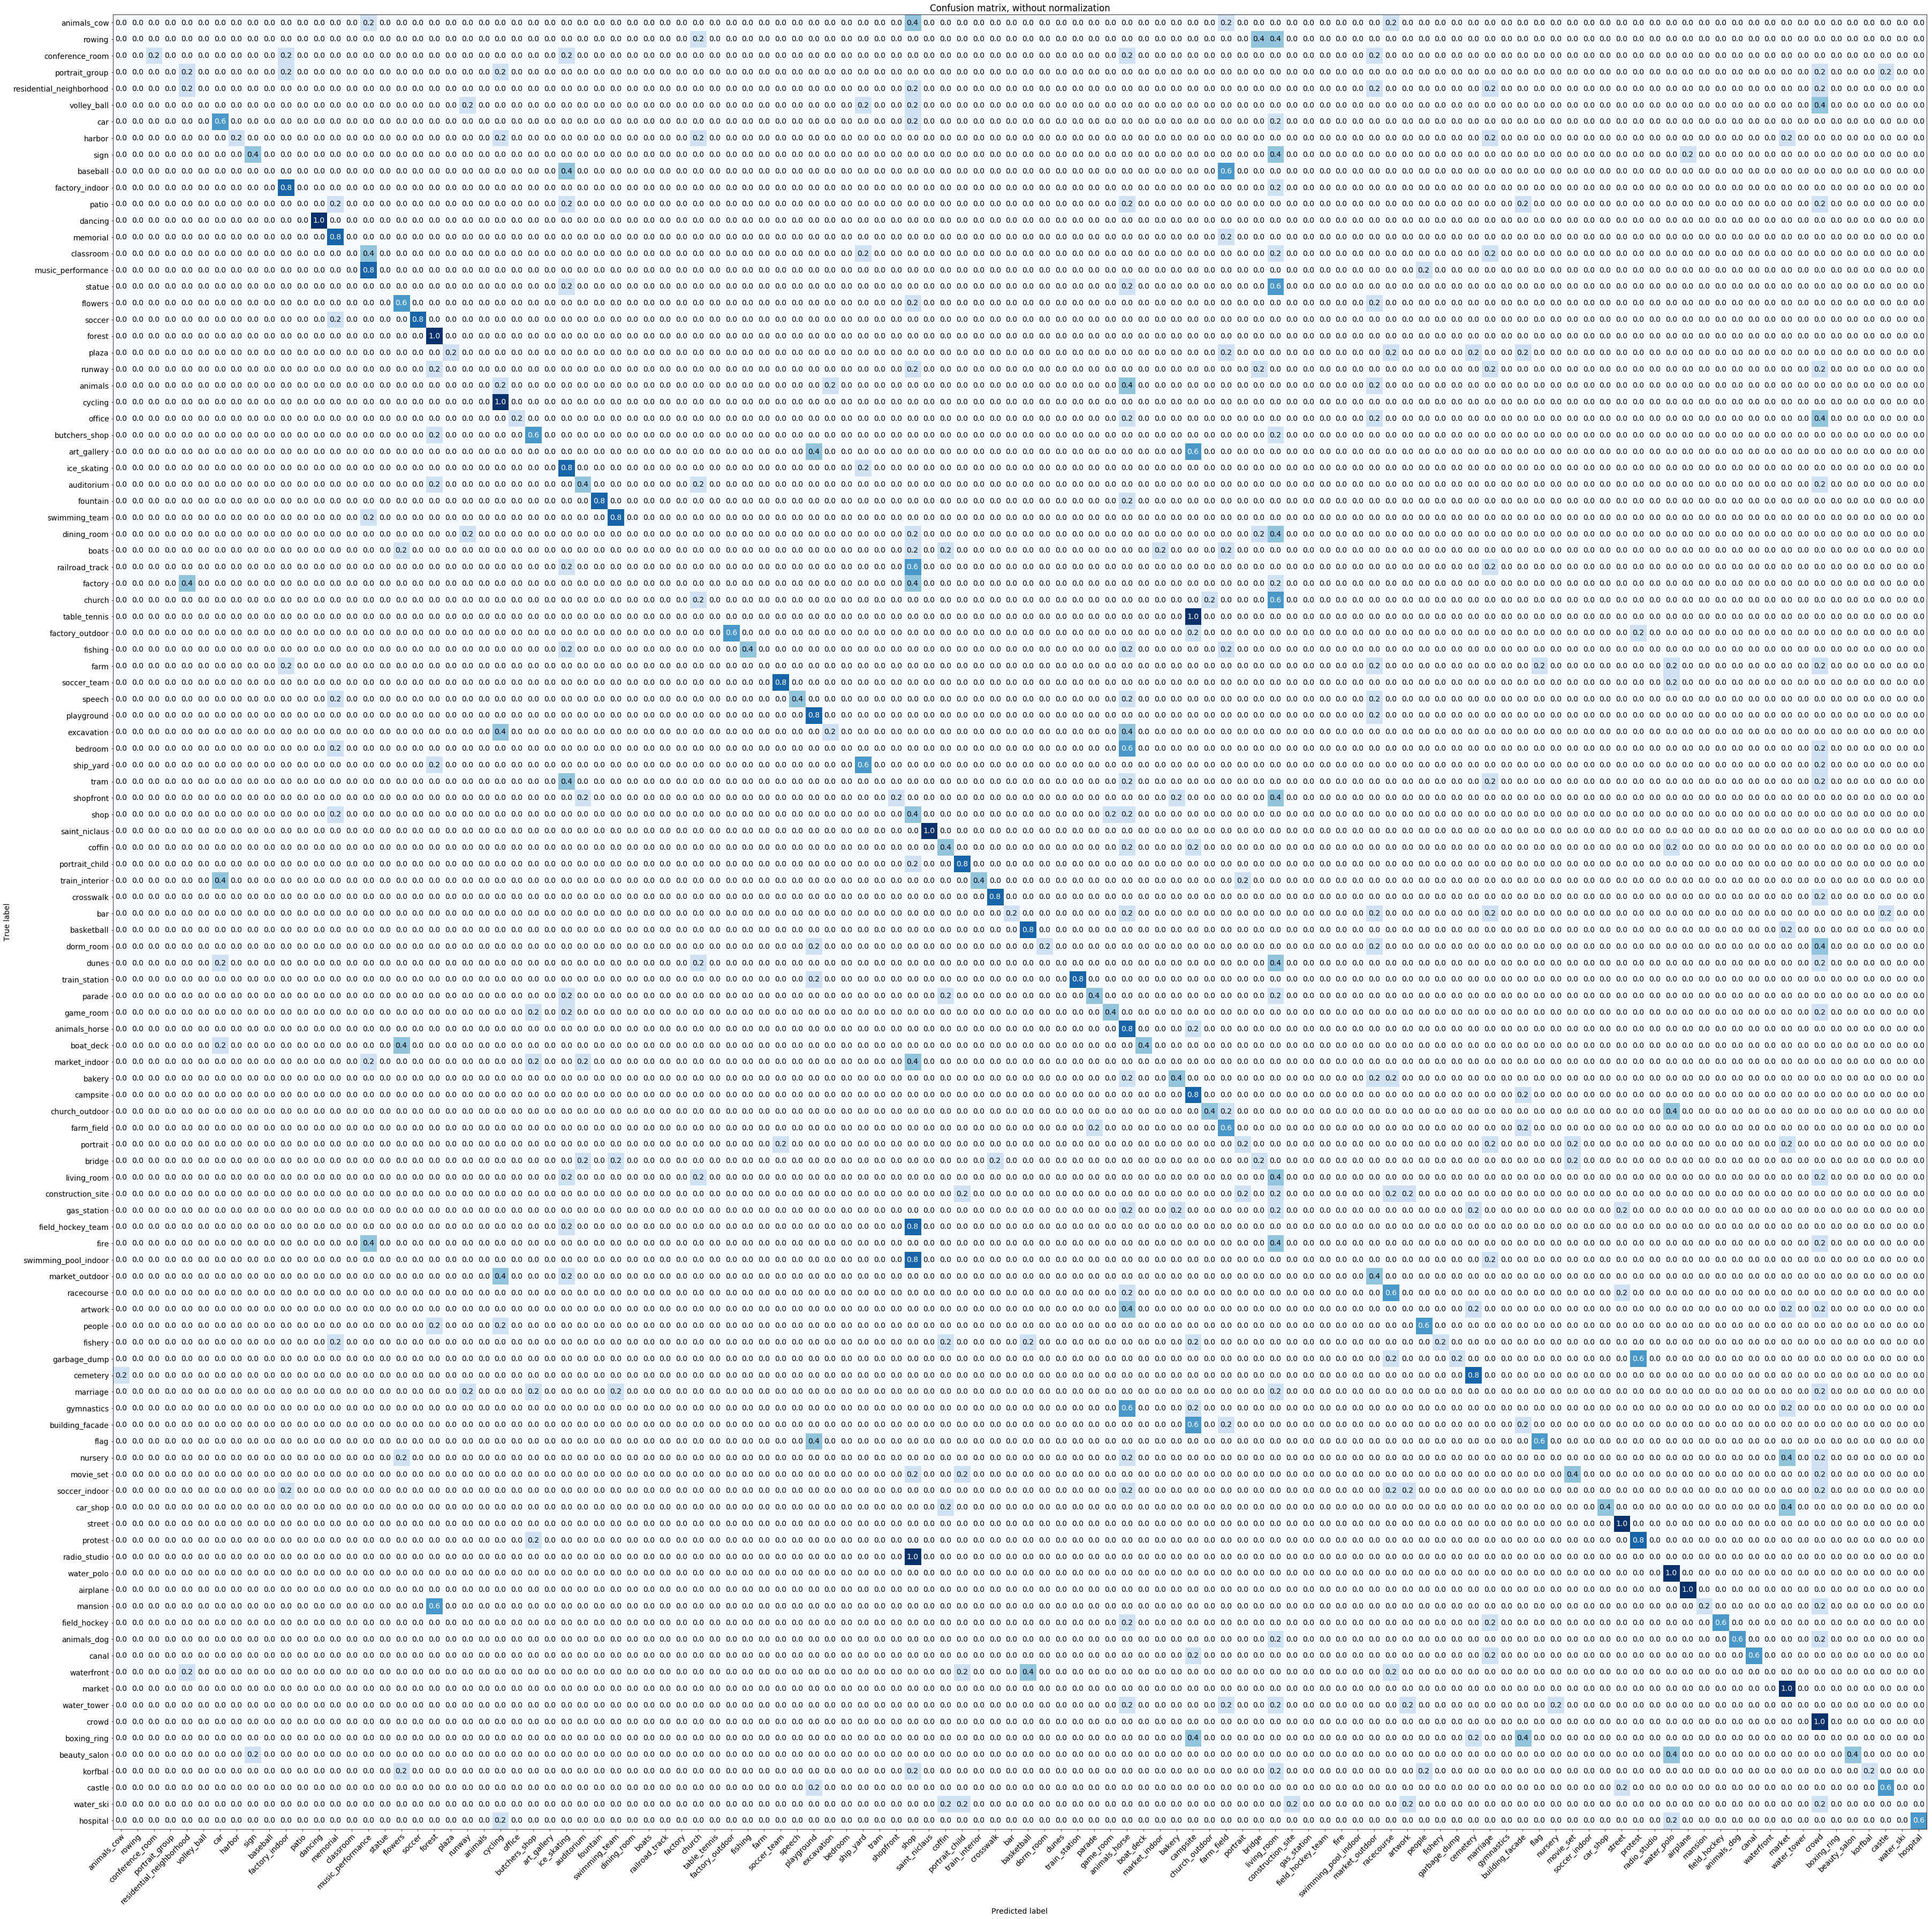

In [62]:
plot_confusion_matrix(y_true, y_pred, classes= categories,normalize=True, title='Confusion matrix, without normalization')